In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import netCDF4 as nc
import datetime as dt
import cmocean
import string
import glob
import pickle
import matplotlib as mpl
from salishsea_tools import evaltools as et
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FormatStrFormatter
#from NorthNut import vvl_interp_T_to_V, vvl_interp_T_to_U;

%matplotlib inline

save only at daily intervals. snapshots of content and sums of hourly rates.

calculations have been moved to transps_calcContentsRates.py

In [2]:
SOGtmaskPath='../../save/SOGtmask.pkl'
(tmaskSOG,ig0,ig1,jg0,jg1)=pickle.load(open(SOGtmaskPath,'rb'))

In [3]:
tmaskSOG.shape,ig0

((1, 40, 898, 398), 110)

In [4]:
SOGmask=tmaskSOG[:,:,jg0:jg1,ig0:ig1]
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    A=np.expand_dims(fm.variables['e1t'][:,jg0:jg1,ig0:ig1]*fm.variables['e2t'][:,jg0:jg1,ig0:ig1],0)

In [5]:
np.shape(A)

(1, 1, 515, 288)

In [6]:
t0=dt.datetime(2015,1,1) # originally 5/15-8/15,  but changed to even number of fortnights (6, end is included)
te=dt.datetime(2015,1,5)
mod_basedir='/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
mod_nam_fmt='nowcast'
mod_flen=1
saveloc='../../save/'
fver='HC201812'
fformat0='%Y%m%d'

In [7]:
fliste3t=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'carp_T',1)
flistPP=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'prod_T',1)
flistB=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'ptrc_T',1)
flistT=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'grid_T',1)

ftype=prod_T, are you sure? (if yes, add to list)


In [8]:
content=dict()
tr={'NO3':'nitrate', 'NH4':'ammonium', 'SIL':'silicon', 'DIAT':'diatoms', 
    'FLAG':'flagellates', 'MRUB':'ciliates', 'MICZ':'microzooplankton', 
    'DON':'dissolved_organic_nitrogen', 'PON':'particulate_organic_nitrogen', 
    'BSI':'biogenic_silicon'}
for el in tr.keys():
    content[el]=np.empty((int((te-t0).days+1),))
rates=dict()
for el in ('PP','NPP','NHtoNO','PPDIAT','SIDIS'):
    rates[el]=np.empty((int((te-t0).days+1),))

In [9]:
# PP=PPPHY+PPDIAT+PPMRUB
# NPP=PPPHYNO3+PPDIATNO3+PPMRUBNO3
# NHtoNO=zz_remin_NH*ammonium^2*TQ10
# SIDIS=zz_remin_D_bSi * bSi * TQ10
zz_remin_NH = 4.0e-7
zz_remin_D_bSi = 2.78e-6

SOGmask24=np.tile(SOGmask,(24,1,1,1))

In [10]:
times=[t0+dt.timedelta(days=ii) for ii in range(0,int((te-t0).total_seconds()/3600/24)+1)]
## calculations
for iif in range(0,len(flistPP)):
    print(iif,dt.datetime.now())
    li0=iif*mod_flen
    li1=(iif+1)*mod_flen
    with nc.Dataset(flistPP.loc[iif,['paths']].values[0]) as fPP, \
          nc.Dataset(flistT.loc[iif,['paths']].values[0]) as fT, \
           nc.Dataset(flistB.loc[iif,['paths']].values[0]) as fB, \
            nc.Dataset(fliste3t.loc[iif,['paths']].values[0]) as fe3t:
        # content
        for ili0 in range(0,mod_flen): # mod_flen is number of days in file
            for el in tr.keys():
                content[el][ili0+li0]=np.sum(1e-3*SOGmask*fB.variables[tr[el]][0,:,jg0:jg1,ig0:ig1]\
                                        *A*fe3t.variables['e3t'][0,:,jg0:jg1,ig0:ig1])
                # mol/mmol * mmol/m3*A*e3t = mol
            # rates
            rates['PP'][ili0+li0]=np.sum(1e-3*3600*SOGmask*(\
                                           fPP.variables['PPDIAT'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1]+\
                                           fPP.variables['PPPHY'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1]+\
                                           fPP.variables['PPMRUB'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1])*\
                                 A*fe3t.variables['e3t'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1])
                # mmol/m3/s *m3 * 3600 s/hr * 1e-3 mol/mmol = mol/hr, per hour, then summed over 24 hrs = mol/day
            rates['NPP'][ili0+li0]=np.sum(1e-3*3600*SOGmask*(\
                                           fPP.variables['PPDIATNO3'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1]+\
                                           fPP.variables['PPPHYNO3'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1]+\
                                           fPP.variables['PPMRUBNO3'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1])*\
                                 A*fe3t.variables['e3t'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1])
            rates['PPDIAT'][ili0+li0]=np.sum(1e-3*3600*SOGmask*(fPP.variables['PPDIAT'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1])*\
                                 A*fe3t.variables['e3t'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1])
            TQ10=np.where(SOGmask24==1,
                 np.exp(0.07*(fT.variables['votemper'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1]-20.0)),0)
            rates['NHtoNO'][ili0+li0]=np.sum(1e-3*3600*SOGmask*zz_remin_NH*\
                                        fB.variables['ammonium'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1]*\
                                        fB.variables['ammonium'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1]*\
                                 TQ10*A*fe3t.variables['e3t'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1])
            rates['SIDIS'][ili0+li0]=np.sum(1e-3*3600*SOGmask*zz_remin_D_bSi*\
                                        fB.variables['biogenic_silicon'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1]*\
                                TQ10*A*fe3t.variables['e3t'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1])

0 2020-02-12 13:11:18.241033
1 2020-02-12 13:12:46.415543
2 2020-02-12 13:14:18.054411
3 2020-02-12 13:15:50.454404
4 2020-02-12 13:17:22.682919


In [11]:
times=np.array(times)
contentPath='../../save/SOGcontent'+t0.strftime(fformat0)+'-'+te.strftime(fformat0)+'.pkl'
pickle.dump((times,content),open(contentPath,'wb'))
ratesPath='../../save/SOGrates'+t0.strftime(fformat0)+'-'+te.strftime(fformat0)+'.pkl'
pickle.dump((times,rates),open(ratesPath,'wb'))

In [19]:
(timesA,rates)=pickle.load(open(ratesPath,'rb'))
(times,content)=pickle.load(open(contentPath,'rb'))

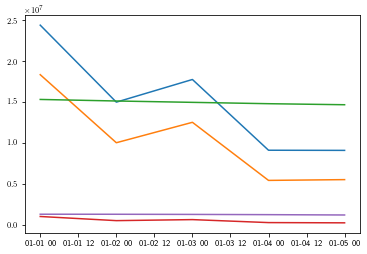

In [27]:
for el in rates.keys():
    plt.plot(timesA,rates[el][:5])

In [29]:
for el in content.keys():
    print(content[el][:5])

[3.66657808e+10 3.67563869e+10 3.68437286e+10 3.68765566e+10
 3.69371952e+10]
[1.11480098e+09 1.11210312e+09 1.11023965e+09 1.10559702e+09
 1.10232632e+09]
[7.16401390e+10 7.18404396e+10 7.20112704e+10 7.20687349e+10
 7.21448746e+10]
[13398232.71706701 13347117.69293735 12715854.41707197 12339108.54861993
 11630250.2813882 ]
[2.43473330e+08 2.48330578e+08 2.44684491e+08 2.43197049e+08
 2.34358721e+08]
[80939882.4534958  82019251.39707573 80510702.56817044 79562506.77980176
 76835027.17489038]
[54195115.76699852 55045419.20023029 55897610.9352733  56365079.61312178
 56328449.05589004]
[85989138.78245701 88426452.25394607 90577480.48418468 91454910.92959091
 91174487.68521976]
[58088534.71748766 59984864.06574098 61669469.12402693 62378062.80372354
 62515022.87584005]
[11041033.89029182 11090982.42718662 11111335.2577212  10904132.01293439
 10638671.12476308]


In [24]:
rates.keys()

dict_keys(['PP', 'NPP', 'NHtoNO', 'PPDIAT', 'SIDIS'])

In [25]:
content.keys()

dict_keys(['NO3', 'NH4', 'SIL', 'DIAT', 'FLAG', 'MRUB', 'MICZ', 'DON', 'PON', 'BSI'])